In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Configuration Options
import sys
np.set_printoptions(threshold=sys.maxsize)

/kaggle/input/imdb-anomaly-detection/imdb.npz
/kaggle/input/adbench/input/musk/musk.csv
/kaggle/input/adbench/input/ionosphere/ionosphere.csv
/kaggle/input/adbench/input/thyroid/thyroid_reduced.csv
/kaggle/input/adbench/input/thyroid/thyroid.csv
/kaggle/input/adbench/input/breast/breastw.csv
/kaggle/input/adbench/input/gamma/gamma.csv
/kaggle/input/adbench/input/cardio/cardio.csv
/kaggle/input/adbench/input/fraud/fraud/fraud.csv
/kaggle/input/adbench/input/wbc/wbc.csv
/kaggle/input/adbench/input/mammography/mammography.csv
/kaggle/input/adbench/input/shuttle/shuttle.csv
/kaggle/input/fraud-train-artifacts/models.pkl
/kaggle/input/fraud-train-artifacts/calibration_scores_std.pkl
/kaggle/input/fraud-train-artifacts/calibration_scores.pkl


# Load Dataset

## Load dataset and perform preprocessing for consumption by MLP and MLP+Jacknife

In [8]:
## Move train artifacts from input to working
import shutil
src = '/kaggle/input/fraud-train-artifacts'
dst = '/kaggle/working/train_artifacts/fraud'
if os.path.exists(dst):
    shutil.rmtree(dst)
# os.makedirs('/kaggle/working/train_artifacts/fraud', exist_ok=True)
shutil.copytree(src, dst, copy_function=shutil.copy2)

'/kaggle/working/train_artifacts/fraud'

In [9]:
# dataset_folder_path = '/kaggle/input/imdb-anomaly-detection'
# dataset_file_name = 'imdb.npz'
# dataset_path = os.path.join(dataset_folder_path, dataset_file_name)

In [10]:
# data = np.load(dataset_path)
# num_features = len(data['X'][0])
# num_records = len(data['X'])
# num_features, num_records

In [11]:
# X = data['X']
# y_true = data['y']
# X_cols = [f'X_{i+1}' for i in range(0, len(X[0]))]

In [12]:
# df = pd.DataFrame(X, columns=X_cols)
# df['y'] = y_true
# df.head()

In [13]:
dataset_folder_path = '/kaggle/input/adbench/input/gamma'
dataset_file_name = 'gamma.csv'
df = pd.read_csv(os.path.join(dataset_folder_path, dataset_file_name))
df.rename(columns={'Class': 'y'}, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,y
0,-0.577211,-0.336795,-0.381120,0.062758,-0.148919,0.541028,0.224812,-0.405831,0.476803,-1.497826,0
1,-0.510955,-0.570012,-0.648578,0.820362,1.471737,0.516906,0.260357,-0.490081,-0.815397,0.153121,0
2,2.568210,6.205695,2.615714,-1.875834,-1.773194,2.044938,-1.478497,-2.182972,1.889174,0.842613,0
3,-0.694749,-0.687241,-1.029451,1.282035,1.606566,0.532757,-0.333506,-0.355350,-0.658786,-1.031436,0
4,0.516609,0.476371,0.711138,-0.347497,-0.284652,-0.020200,0.353077,1.036593,-0.881016,2.176369,0


In [14]:
len(df)

19020

In [15]:
import matplotlib.pyplot as plt
def add_jitter(arr, jitter_strength=0.02):
    return arr + np.random.normal(0, jitter_strength, arr.shape)

def plot_df(df, x_idx, y_idx, y_col = 'y'):
    X = df.drop(y_col, axis=1)
    y = df[y_col]
    print(len(y))

    # Identify normal and anomaly instances
    normal_indices = np.where(y == 0)[0]
    anomaly_indices = np.where(y == 1)[0]
    print(len(normal_indices), len(anomaly_indices))
    
    # Apply jitter to the first two features
    X_jittered = X.copy()
    X_jittered.iloc[:, 0] = add_jitter(X.iloc[:, x_idx])
    X_jittered.iloc[:, 1] = add_jitter(X.iloc[:, y_idx])

    # Plot all instances (using the first two features V1 and V2 for simplicity)
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[normal_indices, x_idx], X_jittered.iloc[normal_indices, y_idx], c='b', label='Normal', alpha=0.5, edgecolor='k')
    plt.scatter(X.iloc[anomaly_indices, x_idx],X_jittered.iloc[anomaly_indices, y_idx], c='r', label='Anomaly', alpha=0.5, edgecolor='k')
    plt.title(f'Global Anomalies for feature V{x_idx + 1} and V{y_idx + 1}')
    plt.xlabel(f'V{x_idx + 1}')
    plt.ylabel(f'V{y_idx + 1}')
    plt.legend()
    plt.show()

In [16]:
# for i in range(8):
#     for j in range(i+1, 9):
#         plot_df(df, i, j)

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=20, shuffle=True, random_state=42)
for i, (train_index, calib_index) in enumerate(kf.split(df)):
    print(len(train_index), len(calib_index))

18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951
18069 951


In [18]:
inliers_df = df.loc[df['y'] == 0]
outliers_df = df.loc[df['y'] == 1]
len(inliers_df), len(outliers_df)

(12332, 6688)

In [19]:
inliers_df_X = inliers_df.drop('y', axis=1)
inliers_df_y = inliers_df['y']
outliers_df_X = outliers_df.drop('y', axis=1)
outliers_df_y = outliers_df['y']
outliers_df_y.head()

12332    1
12333    1
12334    1
12335    1
12336    1
Name: y, dtype: int64

In [20]:
inliers_arr_X = inliers_df_X.to_numpy()
inliers_arr_y = inliers_df_y.to_numpy()
outliers_arr_X = outliers_df_X.to_numpy()
outliers_arr_y = outliers_df_y.to_numpy()
len(inliers_arr_X), len(inliers_arr_y), len(outliers_arr_X), len(outliers_arr_y)

(12332, 12332, 6688, 6688)

# MLP Ensemble Train and Evaluation

In [21]:
# inliers_selection_train_indices = np.random.choice(len(inliers_arr_X), size=int(.9*len(inliers_arr_X)), replace=False)
# outliers_selection_train_indices = np.random.choice(len(outliers_arr_X), size=int(.1*len(outliers_arr_X)), replace=False)
# arr_X = np.vstack([inliers_arr_X[inliers_selection_train_indices], outliers_arr_X[outliers_selection_train_indices]])
# arr_y = np.append(inliers_arr_y[inliers_selection_train_indices], outliers_arr_y[outliers_selection_train_indices])
# len(arr_X), len(arr_y)

In [22]:
# inlier_mask = np.ones(len(inliers_arr_y), dtype=bool)
# inlier_mask[inliers_selection_train_indices] = False
# outlier_mask = np.ones(len(outliers_arr_y), dtype=bool)
# outlier_mask[outliers_selection_train_indices] = False
# outliers_test_X = np.vstack([inliers_arr_X[inlier_mask], outliers_arr_X[outlier_mask]])
# outliers_test_y = np.append(inliers_arr_y[inlier_mask], outliers_arr_y[outlier_mask])
# len(outliers_test_X), len(outliers_test_y)

In [23]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(arr_X, arr_y, test_size=.3, random_state=42)
# len(X_train), len(X_test)

In [24]:
num_models = 5

In [25]:
from sklearn.neural_network import MLPClassifier
import pickle
import shutil

# def fit_member(i):
#     print(f'--------Fitting member: {i}--------------')
#     model = MLPClassifier(hidden_layer_sizes=[600,300,200], max_iter=512, random_state=i, verbose=True)
#     bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
#     X_train_bootstrap = X_train[bootstrap_indices]
#     y_train_bootstrap = y_train[bootstrap_indices]
#     model.fit(X_train_bootstrap, y_train_bootstrap)
#     with open(f'/kaggle/working/models/model_{i}.pkl', 'wb') as f:
#         pickle.dump(model, f)
#     print(f'--------Fitting member: {i} completed--------------')
WORKDIR_PATH = '/kaggle/working'
def create_model_folder(folder_name='models'):
    os.makedirs(os.path.join(WORKDIR_PATH, folder_name), exist_ok=True)
def delete_model_folder(folder_name='models'):
    if os.path.isdir(os.path.join(WORKDIR_PATH, folder_name)):
        shutil.rmtree(os.path.join(WORKDIR_PATH, folder_name))

In [26]:
delete_model_folder()
create_model_folder()

In [27]:
# from multiprocessing import Pool
# from tqdm import tqdm
# i = range(num_models)
# res = tqdm(Pool().imap_unordered(fit_member, i))

In [28]:
# import pickle
# def open_model(i, folder_name='models'):
#     with open(os.path.join(WORKDIR_PATH, folder_name, f'model_{i}.pkl'), 'rb') as f:
#         model = pickle.load(f)
#         return model

In [29]:
# models = []
# for i in range(0, num_models):
#     models.append(open_model(i))

In [30]:
# predictions = np.zeros((len(X_test), num_models))
# predicted_probabilities = np.zeros((len(X_test), num_models*2))

In [31]:
# for i in range(num_models):
#     predictions[:, i] = models[i].predict(X_test)
#     predicted_probabilities[:, i*2:(i+1)*2] = models[i].predict_proba(X_test)

In [32]:
# aggregated_predictions = np.round(np.mean(predictions, axis=1), 2)
# mask = aggregated_predictions >= 0.8
# aggregated_predictions = np.where(mask, (np.ceil(aggregated_predictions)), np.floor(aggregated_predictions)).astype(int)

In [33]:
# predicted_probabilities

In [34]:
# np.unique(aggregated_predictions)
# # np.unique(y_test)

In [35]:
# from sklearn.metrics import accuracy_score, log_loss
# accuracy = accuracy_score(y_test, aggregated_predictions)

In [36]:
# accuracy

In [37]:
# predicted_probabilities.shape

In [38]:
# nll = log_loss(y_test, predicted_probabilities)

In [39]:
# nll

In [40]:
# outlier_predictions = np.zeros((len(outliers_test_X), num_models))
# outlier_predicted_probabilities = np.zeros((len(outliers_test_X), num_models*2))

In [41]:
# for i in range(num_models):
#     outlier_predictions[:, i] = models[i].predict(outliers_test_X)
#     outlier_predicted_probabilities[:, i*2:(i+1)*2] = models[i].predict_proba(outliers_test_X)

In [42]:
# outlier_aggregated_predictions = np.round(np.mean(outlier_predictions, axis=1), 2)
# outlier_mask = outlier_aggregated_predictions >= 0.8
# outlier_aggregated_predictions = np.where(outlier_mask, np.ceil(outlier_aggregated_predictions), np.floor(outlier_aggregated_predictions))

In [43]:
# np.unique(outlier_aggregated_predictions)

In [44]:
# from sklearn.metrics import accuracy_score, log_loss
# accuracy = accuracy_score(outliers_test_y, outlier_aggregated_predictions)
# accuracy

In [45]:
# nll = log_loss(outliers_test_y, outlier_predicted_probabilities)
# nll

# Conformal Prediction

## Create Calibration Sets

In [46]:
len_train = len(inliers_df)//2
len_cal = min(2000, len_train // 2)
len_test = min(2000, len_train // 3)
outlier_pcent = 0.1
len_test_outliers = round(outlier_pcent * len_test)
len_test_inliers = round((1 - outlier_pcent) * len_test)
len_train, len_cal, len_test, len_test_outliers, len_test_inliers

(6166, 2000, 2000, 200, 1800)

In [47]:
from sklearn.svm import OneClassSVM
def perform_bootstrapping(X_train, member_idx, num_members, rnd):
    rnd_state = np.random.RandomState(rnd)
    indices = np.arange(len(X_train))
    rnd_state.shuffle(indices)
    index_sets = np.array_split(indices, num_members)
#     print(member_idx)
    leave_out_indices = index_sets[member_idx]
    mask = np.ones_like(indices, dtype=bool)
    mask[leave_out_indices] = False
    X_train_bootstrap = X_train[mask]
    return X_train_bootstrap, leave_out_indices

def fit_OCSVM_member(member_idx=0, num_members=None, fold_idx=0, X_train=None, random_state=42, save=True):
#     if os.path.isfile(f'/kaggle/working/calib/models/model_{fold_idx}_{member_idx}.pkl'):
#         with open(f'/kaggle/working/calib/models/model_{fold_idx}_{member_idx}.pkl', 'rb') as f:
#             model = pickle.load(f)
#             return model
    if X_train is None:
        return None
    
    model = OneClassSVM(nu = 0.05)
    rnd = hash((member_idx, fold_idx, random_state)) % 4294967296
    rnd = rnd ^ 0x7FFFFFFF
    if num_members is not None:
        X_train_bootstrap, leave_out_indices = perform_bootstrapping(X_train, member_idx, num_members, rnd)
    else:
        X_train_bootstrap = X_train
        leave_out_indices = None
    model.fit(X_train_bootstrap)
    if save:
        with open(f'/kaggle/working/calib/models/model_{fold_idx}_{member_idx}.pkl', 'wb') as f:
            pickle.dump(model, f)
    if leave_out_indices is not None:
        return model, leave_out_indices
    return model
CALIB_PATH_PREFIX = 'calib'
calibration_scores = np.array([], dtype=np.float16)

In [48]:
def scoring_function(x, m, n):
    return m**2 * (1 / (1 + x**2)**2) + n**2 * (x + n**2 - 5)**2

In [49]:
def normalize_scored_sample(calib):
    minval, maxval = calib.min(), calib.max()
    return (calib-minval) / (maxval-minval)
def normalize_scored_sample_2(calib, ground_truth):
    sgn_calib = np.where(calib < 0, -1, 1)
    ground_truth = np.where(ground_truth == 1, -1, 1)
    m = (sgn_calib + ground_truth)
    n = (sgn_calib - ground_truth)
    return 1 - normalize_scored_sample(scoring_function(calib, m, n))
def sigmoid_scored_sample(calib):
    return 1/(1 + np.exp(calib))
def signed_OHE_scored_sample(calib):
    return np.where(calib < 0, 1, 0)

In [50]:
def score_samples(model, calib):
    proba = model.decision_function(calib)
#     print("Proba", np.sort(proba))
#     return proba
    return normalize_scored_sample(proba)

def score_samples_2(model, calib, ground_truth):
    proba = model.decision_function(calib)
    return normalize_scored_sample_2(proba, ground_truth)

def score_samples_3(model, calib, ground_truth):
    proba = model.decision_function(calib)
    return sigmoid_scored_sample(proba)

def score_samples_baseline(model, test, plot=False):
    proba = model.decision_function(test)
    if plot:
        plot_distribution(proba)
    return signed_OHE_scored_sample(proba)


In [51]:
delete_model_folder('/kaggle/working/calib/models')
create_model_folder('/kaggle/working/calib/models')

In [85]:
from sklearn.model_selection import KFold
def create_calibration_sets(train, random_state):
    calibration_scores = np.array([], dtype=np.float16)
    calibration_scores_std = np.array([], dtype=np.float16)
    models = []
    len_splits = len(train) // len_cal if len(train) < 20000 else 20
    kf = KFold(n_splits=len_splits, shuffle=True, random_state=random_state)
    X_train = train.drop('y', axis=1).to_numpy()
    ground_truth = train['y'].to_numpy()
    visited = {}
    print(len_splits)
    for i, (train_index, calib_index) in tqdm(enumerate(kf.split(train)), total=len_splits):
#         print(f'---------------Fold: {i}------------------')
        calibration_scores_i = np.array([], dtype=np.float16)
        calibration_scores_i_leave_out = np.array([], dtype=np.float16)
        for j in range(num_models):
#             print(f'---------------Member: {j}------------------')
            model, leave_out_indices = fit_OCSVM_member(j, num_models, i, X_train[train_index], random_state)
            for idx in calib_index:
                if idx not in visited:
                    visited[idx] = 1
                else:
                    visited[idx] = visited[idx] + 1
            for idx in leave_out_indices:
                if idx not in visited_i:
                    visited_i[idx] = 1
                else:
                    visited_i[idx] = visited_i[idx] + 1
#             print(leave_out_indices.shape)
#             print(leave_out_indices.shape, calib_index.shape)
#             X_calib = X_train[np.append(leave_out_indices, calib_index)]
#             ground_truth_calib = ground_truth[np.append(leave_out_indices, calib_index)]
            calibration_scores_i_j = score_samples_3(model, X_train[calib_index],ground_truth[calib_index])
            calibration_scores_i = np.vstack([calibration_scores_i, calibration_scores_i_j]) if calibration_scores_i.shape[0] > 0 else calibration_scores_i_j
            calibration_scores_leave_out_j = score_samples_3(model, X_train[leave_out_indices],ground_truth[leave_out_indices])
            calibration_scores_i_leave_out = np.append(calibration_scores_i_leave_out, calibration_scores_leave_out_j)
#             plot_distribution(calibration_scores, title="Train Calib scores")
            models.append(model)
        calibration_scores_i_std = np.std(calibration_scores_i, axis=1)
        calibration_scores_i = np.mean(calibration_scores_i, axis=1)
#         print(calibration_scores_i_leave_out)
        calibration_scores = np.append(calibration_scores, calibration_scores_i)
        calibration_scores = np.append(calibration_scores, calibration_scores_i_leave_out)
        calibration_scores_std = np.append(calibration_scores_std, calibration_scores_i_std)
    print(set(visited_i.values()))
    return (models, calibration_scores, calibration_scores_std)

In [86]:
import matplotlib.pyplot as plt

def plot_distribution(data, bins=50, color='blue', alpha=0.7, xlabel='Values', ylabel='Frequency', title='Distribution of Values'):
    """
    Plot a histogram to visualize the distribution of values in the input data.
    
    Parameters:
        data (numpy.ndarray): Input data to plot.
        bins (int, optional): Number of bins for the histogram. Default is 50.
        color (str, optional): Color of the histogram bars. Default is 'blue'.
        alpha (float, optional): Transparency of the histogram bars. Default is 0.7.
        xlabel (str, optional): Label for the x-axis. Default is 'Values'.
        ylabel (str, optional): Label for the y-axis. Default is 'Frequency'.
        title (str, optional): Title of the plot. Default is 'Distribution of Values'.
    """
    plt.hist(data, bins=bins, color=color, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [87]:
def count_less_equal(C, T):
    """
    Count the number of values in C that are less than or equal to each element in T.
    
    Parameters:
        C (numpy.ndarray): Input array C.
        T (numpy.ndarray): Input array T.
        
    Returns:
        numpy.ndarray: New array T' where each element maps to the count of values in C that are less than or equal to the corresponding element in T.
    """
    # Sort array C
    sorted_C = np.sort(C)
    
    # Count the number of elements in C less than or equal to each element in T
    counts = np.searchsorted(sorted_C, T)
    
    return counts

import numpy as np

def count_more_equal(C, T):
    """
    Count the number of values in C that are greater than or equal to each element in T.
    
    Parameters:
        C (numpy.ndarray): Input array C.
        T (numpy.ndarray): Input array T.
        
    Returns:
        numpy.ndarray: New array T' where each element maps to the count of values in C that are greater than or equal to the corresponding element in T.
    """
    # Sort array C in descending order
    sorted_C = np.sort(C)
    # Count the number of elements in C greater than or equal to each element in T
    counts = len(C) - np.searchsorted(sorted_C, T, side='right')
    
    return counts


In [88]:
from scipy import stats
def control_false_positives(p, alpha = 0.2):
    mask = stats.false_discovery_control(p,method='bh') < alpha
#     print(mask)
    mask = mask.astype(int)
#     print(mask)
    return mask
    

In [89]:
def add_noise_to_dataframe(df, noise_level=.1, clip=True):
    for col in df.columns:
        noise = np.random.uniform(low=-1*noise_level, high=noise_level, size=len(df))
        df[col] += noise
        if clip:
            df[col] = np.clip(df[col], 0, 1)   
    return df

In [90]:
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
import sys
from functools import partial
import pickle as pkl

def get_p_values_for_X(models, X_test, ground_truth, qhat, scoring_function=score_samples_3, plot_scores=False):
    if X_test.shape[0] <=0:
        return None
    scores = np.stack([scoring_function(model, X_test, ground_truth) for model in models], axis=1)
    
    scores = np.median(scores, axis=1)
    if plot_scores:
        plot_distribution(scores, title='Scores')
    p_values = (scores > qhat).astype(int)
    return p_values

def get_power(p_values, ground_truth):
    if p_values is None:
        return None
    true_positives = np.sum(p_values == ground_truth)
    false_negatives = np.sum((1 - p_values) == ground_truth)
    power = true_positives / (true_positives + false_negatives)
    return power

def get_fdr(p_values, ground_truth):
    if p_values is None:
        return None
    true_positives = np.sum(p_values == ground_truth)
    false_positives = np.sum(p_values == (1 - ground_truth))
    fdr = false_positives / (true_positives + false_positives)
    return fdr

def train_impl(random_state, save=False, load_saved=False):
    random_state = 42 + random_state
#     print('len inliers df', len(inliers_df))
    train_df, test_df = train_test_split(inliers_df, test_size=len_train, random_state=random_state)
    inliers_test_df_shuffled = test_df.sample(n = len(test_df), random_state = random_state)
    outliers_df_shuffled = outliers_df.sample(n=len(outliers_df), random_state=random_state)
    inliers_indices = np.array_split(inliers_test_df_shuffled.index, L)
    outliers_indices = np.array_split(outliers_df_shuffled.index, L)
#     outliers_in_test_df = outliers_df.drop(outliers_in_train_df.index)
#     print(outliers_in_test_df.head())
#     train_df = pd.concat(
#         [train_df, outliers_in_train_df]
#     )
    if load_saved:
        dataset_name, _ = os.path.splitext(os.path.basename(dataset_file_name))
        folder_name = f'/kaggle/working/train_artifacts/{dataset_name}'
#         if not os.path.isfile(f'{folder_name}/models.pkl') or not os.path.isfile(f'{folder_name}/calibration_scores.pkl') or not os.path.isfile(f'{folder_name}/calibration_scores_std.pkl':
#             print('saved files not found.... performing training again')
#             models, calibration_scores, calibration_scores_std = create_calibration_sets(train_df, random_state)
        with open(f'{folder_name}/models.pkl', 'rb') as f_models:
            models = pkl.load(f_models)
        with open(f'{folder_name}/calibration_scores.pkl', 'rb') as f_calibration_scores:
            calibration_scores = pkl.load(f_calibration_scores)
        with open(f'{folder_name}/calibration_scores_std.pkl', 'rb') as f_calibration_scores_std:
            calibration_scores_std = pkl.load(f_calibration_scores_std)
    else:
        print(len(train_df))
        models, calibration_scores, calibration_scores_std = create_calibration_sets(train_df, random_state)
    if save and not load_saved:
        dataset_name, _ = os.path.splitext(os.path.basename(dataset_file_name))
        folder_name = f'/kaggle/working/train_artifacts/{dataset_name}'
        os.makedirs(folder_name, exist_ok=True)
        with open(f'{folder_name}/models.pkl', 'wb') as f_models:
            pkl.dump(models, f_models)
        with open(f'{folder_name}/calibration_scores.pkl', 'wb') as f_calibration_scores:
            pkl.dump(calibration_scores, f_calibration_scores)
        with open(f'{folder_name}/calibration_scores_std.pkl', 'wb') as f_calibration_scores_std:
            pkl.dump(calibration_scores_std, f_calibration_scores_std)
        return None
    test_impl_func = partial(test_impl, models, calibration_scores)
    res = []
    for l in tqdm(range(L)):
        inliers_df_i = test_df.loc[inliers_indices[l]].reset_index(drop=True)
        outliers_df_i = outliers_df.loc[outliers_indices[l]].reset_index(drop=True)
        plot = None
        if l == 0:
            plot = True
        res.append(test_impl(models, calibration_scores, calibration_scores_std, inliers=inliers_df_i, outliers=outliers_df_i, random_state=l, plot=plot))
    return res
def test_impl(models, calibration_scores, calibration_scores_std, inliers, outliers, random_state, alpha = .05, plot=None):
#     print(len(outliers))
    inliers_in_test_df = inliers.sample(n=round(0.9*len(inliers)), random_state=random_state)
    noisy_inliers = inliers.drop(inliers_in_test_df.index)
    noisy_inliers.drop(columns=['y'], axis=1, inplace=True)
    noisy_inliers = add_noise_to_dataframe(df)
    noisy_inliers['y'] = 0
    test_df = pd.concat(
        [inliers,
#          noisy_inliers,
        outliers],
        ignore_index=True
    )
#     test_df = outliers
#     test_df = inliers_in_test_df
#     test_df = test_df.sample(n=len_test_inliers, random_state=random_state)
    n = len(calibration_scores)
    q_level = np.ceil((n+1)*(1-alpha))/n
#     print(q_level)
#     plot_distribution(calibration_scores, title='Calibration Scores')
    qhat = np.quantile(calibration_scores, q_level, method='higher')
    sigmahat = np.quantile(calibration_scores_std, q_level, method='higher')
#     print(qhat)
#     print(qhat)
#     test_df = outliers
    ground_truth = test_df['y'].values
    X_test = test_df.drop(['y'], axis=1).to_numpy()
    inliers_ground_truth = inliers['y'].values
    X_inliers = inliers.drop(['y'], axis=1).to_numpy()
    outliers_ground_truth = outliers['y'].values
    X_outliers = outliers.drop(['y'], axis=1).to_numpy()
    inlier_p_values = get_p_values_for_X(models, X_inliers, inliers_ground_truth, qhat)
    outlier_p_values = get_p_values_for_X(models, X_outliers, outliers_ground_truth, qhat, plot_scores=False)
    inliers['y_pred'] = inlier_p_values
#     if plot:
#         plot_df(inliers,0,2)
#         plot_df(inliers,0,2, y_col='y_pred')
    outliers['y_pred'] = outlier_p_values
    power_new = get_power(outlier_p_values, outliers_ground_truth)
    fdr_new = get_fdr(inlier_p_values, inliers_ground_truth)
    scores = np.stack([score_samples_3(model, X_test, ground_truth) for model in models], axis=1)
    
#     print("Test scores: ", (scores))
    scores = np.median(scores, axis=1)
#     plot_distribution(scores, title='p-values')
#     print(calibration_scores.shape)
#     counts = count_more_equal(calibration_scores, scores)
#     p_values = (counts + 1) / len(calibration_scores)
#     p_values = control_false_positives(p_values)
    p_values = (scores > qhat).astype(int)
#     plot_distribution(p_values, title="Predicted values")
#     plot_distribution(ground_truth, title="Ground truth")
    true_positives = np.sum(p_values == ground_truth)
    false_negatives = np.sum((1 - p_values) == ground_truth)
    false_positives = np.sum(p_values == (1 - ground_truth))
#     print(true_positives, false_negatives)
    power = true_positives / (true_positives + false_negatives)
    fdr = false_positives / (true_positives + false_positives)
#     return power, fdr
    return power_new, fdr_new, inliers, outliers
#     print(scores.shape)
#     scores = normalize_scored_sample(scores)
    

In [91]:
J, L = 5, 20
j = range(J)

In [92]:
from multiprocessing import Pool
from tqdm import tqdm
res = list(tqdm(Pool().imap_unordered(train_impl, j), total=J))

  0%|          | 0/5 [00:00<?, ?it/s]

616661666166
6166


3333





  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

6166
3


  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'visited_i' is not defined

In [54]:
power_list = []
fdr_list = []
inlier_df_list = []
outlier_df_list = []
for j in range(len(res)):
    if res[j] is None:
            continue
    for l in range(len(res[j])):
        if res[j][l] is None:
            continue
        if res[j][l][0] is not None:
            power_list.append(res[j][l][0])
        if res[j][l][1] is not None:
            fdr_list.append(res[j][l][1])
        if res[j][l][2] is not None:
            inlier_df_list.append(res[j][l][2])
        if res[j][l][3] is not None:
            outlier_df_list.append(res[j][l][3])
len(power_list), len(fdr_list)

(100, 100)

In [55]:
# inlier_df_list

In [56]:
inlier_df_pred = pd.concat(inlier_df_list, axis=0, ignore_index=True)
outlier_df_pred = pd.concat(outlier_df_list, axis=0, ignore_index=True)
test_df_pred = pd.concat([inlier_df_pred, outlier_df_pred], axis=0, ignore_index=True)
test_df_pred.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,y,y_pred
0,-0.507592,-0.713339,-0.939311,0.899131,0.709821,0.766728,-0.014107,-0.564022,-0.363467,-0.313803,0,0
1,-0.717853,-0.458854,-0.638844,0.593354,1.055488,0.173939,0.098311,0.445147,-0.902852,-0.076300,0,0
2,-0.327546,-0.550487,-0.103083,-0.322882,-0.481013,0.380099,0.060658,0.301375,-0.915613,0.096237,0,0
3,-0.827182,-0.637274,-0.992421,1.148566,0.947807,0.049425,-0.064509,-0.302280,0.840358,-1.031436,0,0
4,-0.074936,0.047816,0.533609,-0.830504,-0.855637,0.448831,0.880395,0.742927,-0.842745,0.585989,0,0


In [57]:
inlier_df_pred['y_pred'].value_counts()

y_pred
0    29182
1     1648
Name: count, dtype: int64

30830
30830 0


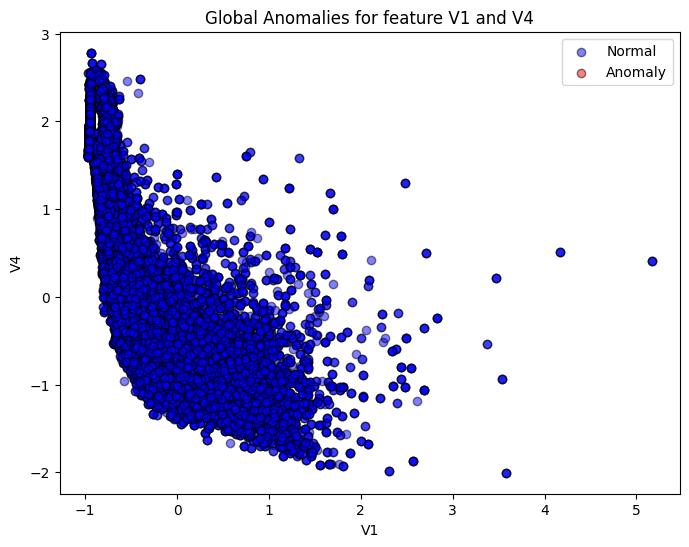

30830
29182 1648


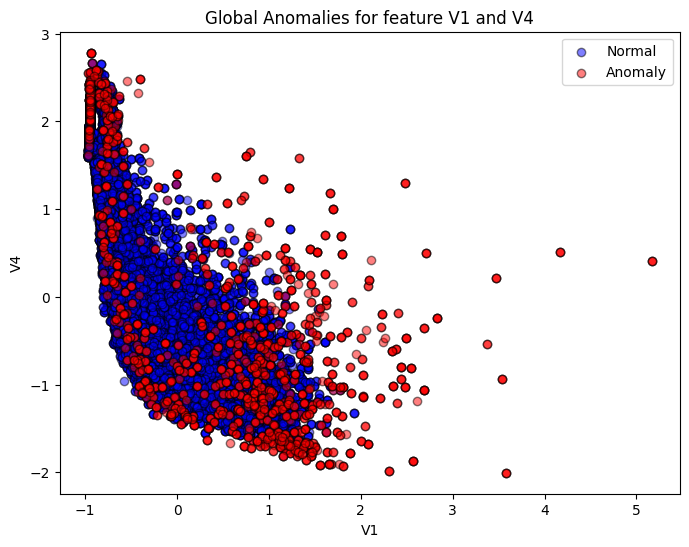

In [58]:
plot_df(inlier_df_pred,0,3)
plot_df(inlier_df_pred,0,3, y_col='y_pred')

In [59]:
len(fdr_list), len(inlier_df_pred)

(100, 30830)

In [60]:
sum(fdr_list)/len(fdr_list)

0.05345374690034884

In [61]:
from statistics import stdev
if len(power_list) > 0 and len(fdr_list) > 0:
    q90_power = np.quantile(power_list, .9)
    q90_fdr = np.quantile(fdr_list, .9)
    avg_power = sum(power_list)/len(power_list)
    avg_fdr = sum(fdr_list)/len(fdr_list)
    std_power = stdev(power_list)
    std_fdr = stdev(fdr_list)
    print("------------------- POWER -------------------")
    print(f"Average Power: \t {avg_power}")
    print(f"90th Quantile Power: \t {q90_power}")
    print(f"Std Power : \t {std_power}")
    print("--------------- FALSE DISCOVERY RATE -----------------")
    print(f"Average FDR: \t {avg_fdr}")
    print(f"90th Quantile FDR: \t {q90_fdr}")
    print(f"Std FDR : \t {std_fdr}")
# avg_power, avg_fdr, q90_power, q90_fdr, std_power, std_fdr

------------------- POWER -------------------
Average Power: 	 0.40858191080525524
90th Quantile Power: 	 0.44776119402985076
Std Power : 	 0.026134519504341563
--------------- FALSE DISCOVERY RATE -----------------
Average FDR: 	 0.05345374690034884
90th Quantile FDR: 	 0.06818181818181818
Std FDR : 	 0.012296629307330897


In [62]:
def evaluate_baseline():
    random_state=42
    train_df, test_df = train_test_split(inliers_df, test_size=len_train, random_state=random_state)
    outliers_in_train_df = outliers_df.sample(n=len_test_outliers, random_state=random_state)
    outliers_in_test_df = outliers_df.drop(outliers_in_train_df.index)
#     train_df = pd.concat(
#         [train_df, outliers_in_train_df]
#     )
    inliers_in_test_df = test_df.sample(n=len_test_inliers, random_state=101)
    noisy_inliers = test_df.drop(inliers_in_test_df.index)
    noisy_inliers.drop(columns=['y'], axis=1, inplace=True)
    noisy_inliers = add_noise_to_dataframe(df)
    noisy_inliers['y'] = 0
    test_df = pd.concat(
        [test_df,
#         noisy_inliers,
        outliers_df],
        ignore_index=True
    )
    train_df = train_df.drop(['y'], axis=1).to_numpy()
#     test_df = outliers_in_test_df
    model = fit_OCSVM_member(X_train=train_df, random_state=random_state, save=False)
    ground_truth = test_df['y'].values
   
    X_inliers = test_df.drop(['y'], axis=1).to_numpy()
    inliers_ground_truth = test_df['y'].values
    X_outliers = outliers_df.drop(['y'], axis=1).to_numpy()
    outliers_ground_truth = outliers_df['y'].values
    inlier_p_values = score_samples_baseline(model, X_inliers)
    outlier_p_values = score_samples_baseline(model, X_outliers, plot=False)
    power_new = get_power(outlier_p_values, outliers_ground_truth)
    fdr_new = get_fdr(inlier_p_values, inliers_ground_truth)
#     alpha = 0.05
#     p_values = (scores < alpha).astype(int)
    test_df = test_df.drop(['y'], axis=1).to_numpy()
    p_values = score_samples_baseline(model, test_df)
    true_positives = np.sum(p_values == ground_truth)
    false_negatives = np.sum((1 - p_values) == ground_truth)
    false_positives = np.sum(p_values == (1 - ground_truth))
#     print(true_positives, false_negatives)
    power = true_positives / (true_positives + false_negatives)
    fdr = false_positives / (true_positives + false_positives)
#     print(power, fdr)
    print(f"Power:\t{power_new}\nFDR:\t{fdr_new}")

In [63]:
evaluate_baseline()

Power:	0.4146232057416268
FDR:	0.330014003423059


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model
from sklearn.model_selection import train_test_split
def build_autoencoder(X_train):
    input_dim = X_train.shape[1]
    encoding_dim = 14  # Number of neurons in the bottleneck layer

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="relu")(input_layer)
    decoder = Dense(input_dim, activation="sigmoid")(encoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

def evaluate_autoencoder():
    random_state=10001
    train_df, test_df = train_test_split(inliers_df, test_size=len_train, random_state=random_state)
#     test_df = pd.concat([test_df, outliers_df])
    X_inliers = test_df.drop(['y'], axis=1).to_numpy()
    inliers_ground_truth = test_df['y'].values
    X_outliers = outliers_df.drop(['y'], axis=1).to_numpy()
    outliers_ground_truth = outliers_df['y'].values
    X_train = train_df.drop(['y'], axis=1).to_numpy()
    ground_truth = test_df['y'].values
    X_test = test_df.drop(['y'], axis=1).to_numpy()
    autoencoder = build_autoencoder(X_train)
    autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test),
                )
    X_train_pred = autoencoder.predict(X_train)
    train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

    # Set a threshold for anomaly detection
    threshold = np.percentile(train_mse, 90)  # 90th percentile of MSE
    print(f"Threshold: {threshold}")
    
    X_inliers_pred = autoencoder.predict(X_inliers)
    inliers_test_mse = np.mean(np.power(X_inliers - X_inliers_pred, 2), axis=1)
    inliers_test_pred = np.where(inliers_test_mse > threshold, 1, 0)
    fdr = get_fdr(inliers_test_pred, inliers_ground_truth)
    
    X_outliers_pred = autoencoder.predict(X_outliers)
    outliers_test_mse = np.mean(np.power(X_outliers - X_outliers_pred, 2), axis=1)
    outliers_test_pred = np.where(outliers_test_mse > threshold, 1, 0)
    power = get_power(outliers_test_pred, outliers_ground_truth)
    
    return power, fdr
    

In [ ]:
evaluate_autoencoder()

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
